## Notebook description
This notebook uses PyTorch framework<br>
and AWS SageMaker to train an image classifier<br>
to classify blood cell images.<br><br>

The classification is based on ResNet-50 neural network that we fine-tune here for the target dataset<br>
while utilizing SageMaker profiling, debugger, and hyperparameter tuning.<br>

## Install and import

In [1]:
!pip install smdebug
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 22.6 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110685 sha256=d00887bd2aea9c1fc7219cc605ddfaa47f6d410f080644a7199de04b2afbbd20
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c0/1c/32/08c3136bdbd53bf754d0fd636f9b4a134dd317af2fbecc143d
Successfully built kaggle


In [2]:
import os
import IPython
import requests
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3


from zipfile import ZipFile

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## About the Dataset
For this project I use dataset containing blood cell images published on Kaggle.<br>
The dataset contains augmented images for 4 different blood cell types:
- Eosinophil
- Lymphocyte
- Monocyte
- Neutrophil

There are approximately 3,000 images for each of 4 different cell types<br>
grouped into 4 different folders (according to cell type)

## Download the dataset

In [3]:
# Dodnwload data from kaggle

os.environ['KAGGLE_USERNAME'] = "jmarcan"
os.environ['KAGGLE_KEY'] = "843d5de957bd3184a6bed9d9015f97d6"
!kaggle datasets download -d paultimothymooney/blood-cells

# Unzip the dataset
with ZipFile("blood-cells.zip", 'r') as zObject:
  
    # Extracting zip
    zObject.extractall(
        path="blood-cells")

 95%|██████████████████████████████████████  | 103M/108M [00:03<00:00, 42.1MB/s]
100%|████████████████████████████████████████| 108M/108M [00:03<00:00, 33.5MB/s]


## Explore the dataset

In [4]:
train_path = "blood-cells/dataset2-master/dataset2-master/images/TRAIN/"
test_path = "blood-cells/dataset2-master/dataset2-master/images/TEST/"

### Analyze number of samples

In [5]:
import glob as gb

for folder in  os.listdir(train_path) : 
    files = gb.glob(pathname= str(train_path + folder +'/*.jpeg'))
    print(f'For training data found {len(files)} samples in folder {folder}')
    
for folder in  os.listdir(test_path) : 
    files = gb.glob(pathname= str(test_path + folder + '/*.jpeg'))
    print(f'For testing data found {len(files)} samples in folder {folder}')

For training data found 2499 samples in folder NEUTROPHIL
For training data found 2497 samples in folder EOSINOPHIL
For training data found 2483 samples in folder LYMPHOCYTE
For training data found 2478 samples in folder MONOCYTE
For testing data found 624 samples in folder NEUTROPHIL
For testing data found 623 samples in folder EOSINOPHIL
For testing data found 620 samples in folder LYMPHOCYTE
For testing data found 620 samples in folder MONOCYTE


### Visualize image for each class

In [6]:
import cv2
import matplotlib.pyplot as plt

def visualize_image(img_path):
    image = cv2.imread(img_path)
    plt.imshow(image)
    plt.show()

Matplotlib is building the font cache; this may take a moment.


EOSINOPHIL


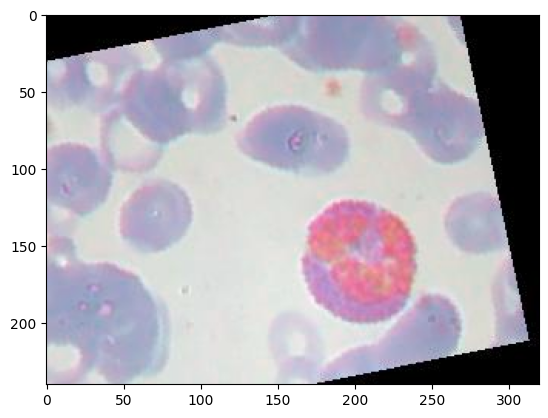

LYMPHOCYTE


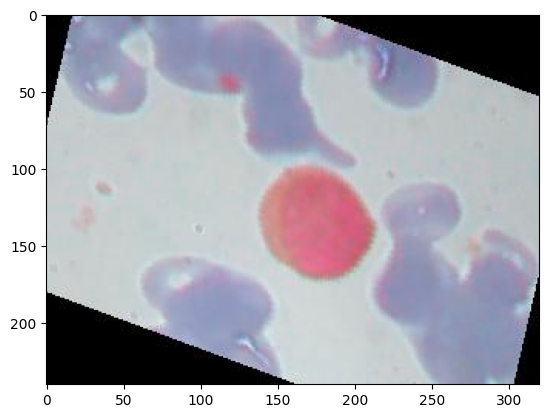

MONOCYTE


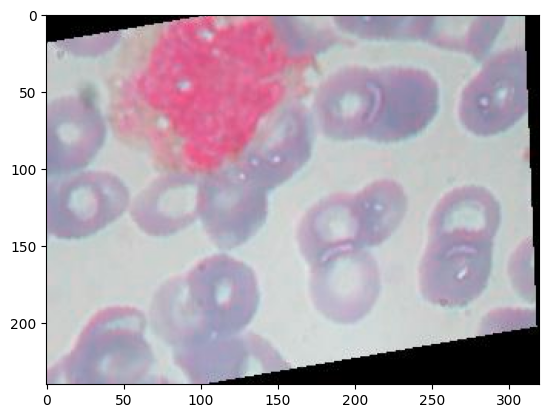

NEUTROPHIL


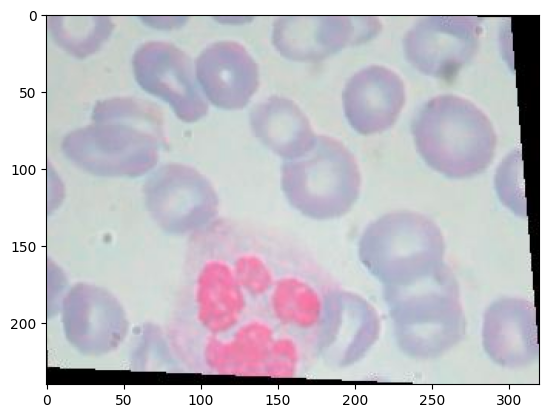

In [7]:
# EOSINOPHIL
print("EOSINOPHIL")
visualize_image("blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_1414.jpeg")

# LYMPHOCYTE
print("LYMPHOCYTE")
visualize_image("blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_1063.jpeg")

# MONOCYTE
print("MONOCYTE")
visualize_image("blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_4446.jpeg")

# NEUTROPHIL
print("NEUTROPHIL")
visualize_image("blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_100_8981.jpeg")

## Upload data to s3

In [4]:
# Initialize S3 bucket and SageMaker session

import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role

sagemaker_session = Session(default_bucket='image-classification-blood-cells')

bucket= sagemaker_session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = sagemaker_session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: image-classification-blood-cells
AWS Region: eu-central-1
RoleArn: arn:aws:iam::095004543442:role/service-role/AmazonSageMaker-ExecutionRole-20201027T160547


In [9]:
# Upload data to S3
s3_path_to_data = sagemaker_session.upload_data(bucket=bucket, 
                                                  path='blood-cells', 
                                                  key_prefix='blood-cells')

## Configure artifact repository for model

In [64]:
s3_output_location = f"s3://{bucket}/trained_model"

## Reference the dataset dataset

In [5]:
data_s3path = f"s3://{bucket}/blood-cells/dataset2-master/dataset2-master/images/"

## Hyperparameter Tuning
In this part we finetune a pretrained model with hyperparameter tuning

In [6]:
# Hyperparameter ranges
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.01, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128]),
    "epochs": IntegerParameter(5, 10)
}

In [7]:
# Objective metric
objective_metric_name = "Test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [8]:
# SageMaker's Estimator
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="pytorch-training-hyperparameters-range",
    role=role,
    py_version="py310",
    framework_version="2.0.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

# SageMaker's Tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    output_path=s3_output_location,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    objective_type=objective_type
)

### Fit the tuner

In [18]:
# Fit Tuner
tuner.fit(inputs={"data": data_s3path}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230819-0813


Using provided s3_resource
..........................................................................................................................................!


### Store the best hyperparameters

In [19]:
# Read the best hyperparameters
best_estimator = tuner.best_estimator()
print(best_estimator.hyperparameters())


2023-08-19 08:22:13 Starting - Preparing the instances for training
2023-08-19 08:22:13 Downloading - Downloading input data
2023-08-19 08:22:13 Training - Training image download completed. Training in progress.
2023-08-19 08:22:13 Uploading - Uploading generated training model
2023-08-19 08:22:13 Completed - Resource reused by training job: pytorch-training-230819-0813-002-e14bc998
{'_tuning_objective_metric': '"Test loss"', 'batch_size': '"128"', 'epochs': '5', 'learning_rate': '0.07838046044459387', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-hyperparameters-range-2023-08-19-08-13-27-643"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"eu-central-1"', 'sagemaker_submit_directory': '"s3://sagemaker-eu-central-1-095004543442/pytorch-training-hyperparameters-range-2023-08-19-08-13-27-643/source/sourcedir.tar.gz"'}


In [20]:
# Store the best hyperparameters
hyperparameters = {"learning_rate": best_estimator.hyperparameters()['learning_rate'],
                   "batch_size": best_estimator.hyperparameters()['batch_size'],
                   "epochs": best_estimator.hyperparameters()['epochs']
                  }
print(hyperparameters)

{'learning_rate': '0.07838046044459387', 'batch_size': '"128"', 'epochs': '5'}


## Model Profiling and Debugging
Here we use the best parameters to create and finetune a new model

In [21]:
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile

In [22]:
# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [62]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="pytorch-training-hyperparameters-best",
    role=role,
    py_version="py310",
    framework_version="2.0.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    ## Debugger and Profiler parameters
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
estimator.fit(inputs={"data": data_s3path}, wait=True)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-hyperparameters-best-2023-08-19-16-14-46-979


Using provided s3_resource
2023-08-19 16:14:47 Starting - Starting the training job...
2023-08-19 16:15:15 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-08-19 16:16:15 Downloading - Downloading input data.........
2023-08-19 16:17:45 Training - Downloading the training image....................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-19 16:21:00,711 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-19 16:21:00,728 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-08-19 16:21:00,738 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-08-19 16:21:00,744 sagemaker_pytorch_container.training INFO     Invoking user training script.


2023-08-19 16:21:17 Training - Training image download completed. Training in progress.35%|███▍      | 33.8M/97.8M [00:00<00:00, 76.3MB/s]
43%|████▎     | 41.9M/97.8M [00:00<00:00, 79.1MB/s]
51%|█████     | 49.8M/97.8M [00:00<00:00, 62.5MB/s]
59%|█████▊    | 57.4M/97.8M [00:00<00:00, 66.9MB/s]
67%|██████▋   | 65.3M/97.8M [00:00<00:00, 71.4MB/s]
75%|███████▌  | 73.8M/97.8M [00:01<00:00, 76.3MB/s]
84%|████████▎ | 81.8M/97.8M [00:01<00:00, 78.4MB/s]
92%|█████████▏| 89.6M/97.8M [00:01<00:00, 64.9MB/s]
100%|██████████| 97.8M/97.8M [00:01<00:00, 70.7MB/s]
[2023-08-19 16:21:08.689 algo-1:41 INFO json_config.py:92] Creating hook from json_config at /opt/ml/input/config/debughookconfig.json.
[2023-08-19 16:21:08.691 algo-1:41 INFO hook.py:206] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
[2023-08-19 16:21:08.692 algo-1:41 INFO hook.py:259] Saving to /opt/ml/output/tensors
[2023-08-19 16:21:08.693 algo-1:41 INFO state_store.py:77] The check

### Display profiler report

In [24]:
# Print tensor names
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2023-08-19 08:37:17.273 ip-172-16-49-44.eu-central-1.compute.internal:6266 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-eu-central-1-095004543442/pytorch-training-hyperparameters-best-2023-08-19-08-26-33-355/debug-output
[2023-08-19 08:37:20.322 ip-172-16-49-44.eu-central-1.compute.internal:6266 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-08-19 08:37:21.344 ip-172-16-49-44.eu-central-1.compute.internal:6266 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

Tensors Train: 79
Tensors Valid:  20
TRAIN data loading
VALID data loading


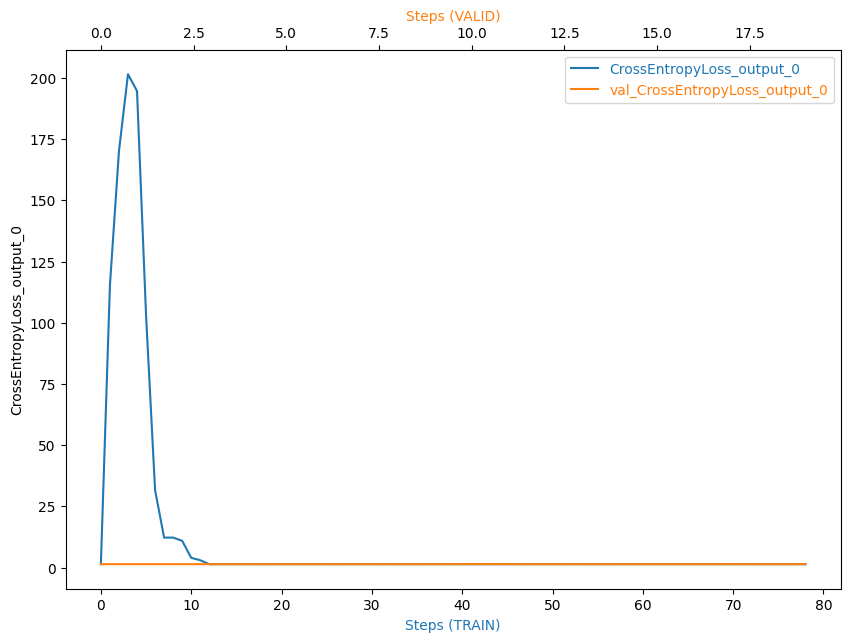

In [25]:
#Plotting a debugging output

print(f'Tensors Train: {len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))}')
print(f'Tensors Valid:  {len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))}')

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("TRAIN data loading")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("VALID data loading")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (VALID)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [63]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://image-classification-blood-cells/trained_model/pytorch-training-hyperparameters-best-2023-08-19-16-14-46-979/rule-output


In [27]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2023-08-19 08:35:23     343121 pytorch-training-hyperparameters-best-2023-08-19-08-26-33-355/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-08-19 08:35:22     193721 pytorch-training-hyperparameters-best-2023-08-19-08-26-33-355/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-08-19 08:35:18        191 pytorch-training-hyperparameters-best-2023-08-19-08-26-33-355/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-08-19 08:35:18       9227 pytorch-training-hyperparameters-best-2023-08-19-08-26-33-355/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-08-19 08:35:18        126 pytorch-training-hyperparameters-best-2023-08-19-08-26-33-355/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-08-19 08:35:18        129 pytorch-training-hyperparameters-best-2023-08-19-08-26-33-355/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json


In [28]:
# Display the profiler output

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deployment

In [45]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor



jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [80]:
model_location=estimator.model_data
print(model_location)

s3://image-classification-blood-cells/trained_model/pytorch-training-hyperparameters-best-2023-08-19-16-14-46-979/output/model.tar.gz


In [120]:
# We make use of an inference script, for creating a Pytorch Model from the trained model above, 
# which we can query with the endpoint with inputs
env_variables_dict = {
    "SAGEMAKER_TS_MIN_WORKERS": "1",
    "SAGEMAKER_TS_MAX_WORKERS": "1", # by default sagemaker starts 4 workers
}

pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py310',
                             framework_version="2.0.0",
                             predictor_cls=ImagePredictor,
                             env=env_variables_dict
                )

In [121]:
# Deploy the model to an endpoint
predictor=pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Repacking model artifact (s3://image-classification-blood-cells/trained_model/pytorch-training-hyperparameters-best-2023-08-19-16-14-46-979/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-eu-central-1-095004543442/pytorch-inference-2023-08-19-21-38-03-559/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-08-19-21-38-11-663
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-08-19-21-38-12-324
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-08-19-21-38-12-324


----!

In [122]:
# The predict function takes as input an image_url, preprocesses it, and uses the endpoint for prediction
import numpy
import requests
from PIL import Image
import torchvision.transforms as transforms

def read_image_from_s3(image_s3_key, bucket=bucket, region_name=region):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    s3 = boto3.resource('s3', region_name)
    bucket = s3.Bucket(bucket)
    object = bucket.Object(image_s3_key)
    response = object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    return im

def predict(image_s3_key):
    
    image = read_image_from_s3(image_s3_key)
    
    # visualize the image
    plt.imshow(image)
    plt.show()
    
    # print prediction from the model
    response = predictor.predict(image, request_content_type='image/png')
    pred = np.argmax(response, 1)+1
    print(f"Actual: {image_s3_key}, Prediction: {pred[0]}")

In [ ]:
# Images to test prediction
image_paths = ["blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_1414.jpeg"]

for path in image_paths:
    predict(path)

In [ ]:
# Shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()